<a href="https://colab.research.google.com/github/chiranjeet14/ML_Projects/blob/master/Competition/churn_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn
# ^^^ pyforest auto-imports - don't write above this line
# # Additional packages
# !pip3 install category_encoders > /dev/null
!pip3 install pandas_profiling > /dev/null
# !pip3 install imbalanced-learn > /dev/null
!pip3 install catboost > /dev/null
!pip3 install xgboost > /dev/null
!pip3 install boto3 > /dev/null
!pip3 install lazypredict > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import io
import gc

# settings
import warnings
warnings.filterwarnings("ignore")
gc.enable()

In [ ]:
!mkdir -p /home/jovyan/work/dataset

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# Calculating Precision, Recall and f1-score
def model_score(actual_value,predicted_values):
  from sklearn.metrics import confusion_matrix 
  from sklearn.metrics import accuracy_score 
  from sklearn.metrics import classification_report 
  from sklearn.metrics import recall_score
  from sklearn.metrics import roc_auc_score
  
  actual = actual_value
  predicted = predicted_values
  results = confusion_matrix(actual, predicted) 
  
  print('Confusion Matrix :')
  print(results) 
  print('Accuracy Score :',accuracy_score(actual, predicted))
  print('Report : ')
  print(classification_report(actual, predicted))
  print('Recall Score : ')
  print(recall_score(actual, predicted))
  print('ROC AUC Score : ')
  print(roc_auc_score(actual, predicted))

In [ ]:
train_file_id = '12M1iRXbgtpON2cDlu0bvwePhgHcc9d9I'
test_file_id = '12CnSdigZ1wYDEsVJfD8kWlOrlx38Dt-u'
train_file_destination = '/home/jovyan/work/dataset/churn_train.csv'
test_file_destination = '/home/jovyan/work/dataset/churn_test.csv'
download_file_from_google_drive(train_file_id, train_file_destination)
download_file_from_google_drive(test_file_id, test_file_destination)

In [ ]:
rows_to_read = None
df_train = pd.read_csv('/home/jovyan/work/dataset/churn_train.csv', na_values=['?', 'Unknown'], nrows=rows_to_read)
df_test = pd.read_csv('/home/jovyan/work/dataset/churn_test.csv', na_values=['?', 'Unknown'], nrows=rows_to_read)

target_feature = 'churn_risk_score'

In [ ]:
# from pandas_profiling import ProfileReport
# report = ProfileReport(df_train, title='Pandas Profiling Report', explorative=True)
# report.to_file("churn_report.html")
# # report

## Preprocessing

### Drop unnecessary columns

In [ ]:
columns_to_drop = ['customer_id', 'Name', 'security_no', 'referral_id', 'last_visit_time']

df_train.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
df_test.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

In [ ]:
def preprocess_date(dataFrame, field):
    dataFrame[field] = pd.to_datetime(dataFrame[field])
    dataFrame['joining_year'] = dataFrame[field].dt.year
    dataFrame['joining_month'] = dataFrame[field].dt.month
    dataFrame['joining_day'] = dataFrame[field].dt.day
    dataFrame['joining_dayOfWeek'] = dataFrame[field].dt.dayofweek
    dataFrame['joining_weekdayName'] = dataFrame[field].dt.day_name()
    dataFrame['joining_week'] = dataFrame[field].dt.week
    dataFrame['joining_weekOfYear'] = dataFrame[field].dt.weekofyear
    dataFrame['joining_dayOfYear'] = dataFrame[field].dt.dayofyear
    dataFrame['joining_daysInMonth'] = dataFrame[field].dt.days_in_month
    return dataFrame

In [ ]:
df_train = preprocess_date(df_train, 'joining_date')
df_test = preprocess_date(df_test, 'joining_date')

df_train.drop('joining_date', axis=1, inplace=True, errors='ignore')
df_test.drop('joining_date', axis=1, inplace=True, errors='ignore')

In [ ]:
def get_categorical_features(dataFrame):
    categorical_feats = [
        f for f in dataFrame.columns if dataFrame[f].dtype == 'object'
    ]
    return categorical_feats

def get_non_categorical_features(dataFrame, categorical_feats):
    non_categorical_features  = [
        f for f in dataFrame.columns if f not in categorical_feats
    ]
    return non_categorical_features

def remove_element_from_list(list_of_elements, element):
    if element in list_of_elements: list_of_elements.remove(element)
    return list_of_elements

In [ ]:
categorical_features = get_categorical_features(df_train)
non_categorical_features = get_non_categorical_features(df_train, categorical_features)
non_categorical_features = remove_element_from_list(non_categorical_features, target_feature)

In [ ]:
# categorical_features

In [ ]:
# non_categorical_features

In [ ]:
def convert_to_categorical(dataFrame, field):
    dataFrame[field] = dataFrame[field].astype('category')
    return dataFrame

def convert_to_numeric(dataFrame, field):
    dataFrame[field] = dataFrame[field].apply(pd.to_numeric, errors='coerce')
    return dataFrame

def imput_to_numeric(dataFrame, field):
    return dataFrame

In [ ]:
df_train = convert_to_categorical(df_train, categorical_features)
df_train = convert_to_categorical(df_train, [target_feature])
df_train = convert_to_numeric(df_train, non_categorical_features)

df_test = convert_to_categorical(df_test, categorical_features)
df_test = convert_to_numeric(df_test, non_categorical_features)

In [ ]:
# df_train.head()

In [ ]:
# Check column type
# for col in df_train_new.columns:
#     print("{} : {}".format(col,df_train_new[col].dtype))

In [ ]:
# non_categorical_features NAN values
# df_train[non_categorical_features].isna().sum()

In [ ]:
# categorical_features NAN values
# df_train[categorical_features].isna().sum()

### Replacing categorical_features NaN values

In [ ]:
# def replace_nan_category(dataFrame, field, new_category):
#     available_categories = list(dataFrame[field].value_counts().index)
#     if new_category not in available_categories:
#         dataFrame[field] = dataFrame[field].cat.add_categories([new_category])
#         dataFrame[field].fillna(new_category, inplace=True)
#     return dataFrame

In [ ]:
# df_train = replace_nan_category(df_train, 'region_category', 'Region Not Specified')
# df_train = replace_nan_category(df_train, 'joined_through_referral', 'Not Applicable')
# df_train = replace_nan_category(df_train, 'preferred_offer_types', 'Not Applicable')
# df_train = replace_nan_category(df_train, 'medium_of_operation', 'Not Applicable')
# df_train = replace_nan_category(df_train, 'gender', 'Not Applicable')

# df_test = replace_nan_category(df_test, 'region_category', 'Region Not Specified')
# df_test = replace_nan_category(df_test, 'joined_through_referral', 'Not Applicable')
# df_test = replace_nan_category(df_test, 'preferred_offer_types', 'Not Applicable')
# df_test = replace_nan_category(df_test, 'medium_of_operation', 'Not Applicable')
# df_test = replace_nan_category(df_test, 'gender', 'Not Applicable')

In [ ]:
# df_train.head()

In [ ]:
def fill_NaN_values(dataFrame, field, value):
    dataFrame[field].fillna(value, inplace=True)
    return dataFrame

In [ ]:
df_train = fill_NaN_values(df_train, 'region_category', df_train['region_category'].mode()[0])
df_train = fill_NaN_values(df_train, 'joined_through_referral', df_train['joined_through_referral'].mode()[0])
df_train = fill_NaN_values(df_train, 'preferred_offer_types', df_train['preferred_offer_types'].mode()[0])
df_train = fill_NaN_values(df_train, 'medium_of_operation', df_train['medium_of_operation'].mode()[0])
df_train = fill_NaN_values(df_train, 'gender', df_train['gender'].mode()[0])

df_test = fill_NaN_values(df_test, 'region_category', df_test['region_category'].mode()[0])
df_test = fill_NaN_values(df_test, 'joined_through_referral', df_test['joined_through_referral'].mode()[0])
df_test = fill_NaN_values(df_test, 'preferred_offer_types', df_test['preferred_offer_types'].mode()[0])
df_test = fill_NaN_values(df_test, 'medium_of_operation', df_test['medium_of_operation'].mode()[0])
df_test = fill_NaN_values(df_test, 'gender', df_test['gender'].mode()[0])

### Transfroming target_feature

In [ ]:
# Replacing -1 in train data with 1
df_train[target_feature] = df_train[target_feature].apply(lambda x:1 if x == -1 else 0 if x == 5 else x)
df_train[target_feature].unique()

array([2, 1, 0, 3, 4])

In [ ]:
df_train.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,...,churn_risk_score,joining_year,joining_month,joining_day,joining_dayOfWeek,joining_weekdayName,joining_week,joining_weekOfYear,joining_dayOfYear,joining_daysInMonth
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,17,300.63,...,2,2017,8,17,3,Thursday,33,33,229,31
1,32,F,City,Premium Membership,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,16,306.34,...,1,2017,8,28,0,Monday,35,35,240,31
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14,516.16,...,0,2016,11,11,4,Friday,45,45,316,30
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11,53.27,...,0,2016,10,29,5,Saturday,43,43,303,31
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20,113.13,...,0,2017,9,12,1,Tuesday,37,37,255,30


### Label Encoding categorical_features

ref: http://kagglesolutions.com/r/feature-engineering--label-encoding

Since we have two different datasets (X_train and X_test) we need to fit it on all of your data otherwise there might be some categories in the test set X_test that were not in the train set X_train and we will get errors.

To resolve this issue we will first concatenate X_train and X_test together and then perform label encoding.

In [ ]:
df_train2=df_train.assign(dataType="train-data")
df_test2=df_test.assign(dataType="test-data")

In [ ]:
# Add an indicator column while concatenating the two dataframes, so we can later seperate them again:
df_combined = pd.concat([df_train2, df_test2], ignore_index=True, axis=0)

In [ ]:
from sklearn import preprocessing

label_object = {}
for col in categorical_features:
    labelencoder = preprocessing.LabelEncoder()
    labelencoder.fit(df_combined[col].astype(str))
    df_combined[col] = labelencoder.fit_transform(df_combined[col].astype(str))
    label_object[col] = labelencoder

In [ ]:
# Split data into tain and test
df_test, df_train = df_combined[df_combined["dataType"].eq("test-data")], df_combined[df_combined["dataType"].eq("train-data")]

# Drop dataType column
df_train.drop('dataType', axis=1, inplace=True, errors='ignore')
df_test.drop('dataType', axis=1, inplace=True, errors='ignore')

In [ ]:
# Sample inverse_transform
label_object['medium_of_operation'].inverse_transform(df_train['medium_of_operation'][:5])

array(['Desktop', 'Desktop', 'Desktop', 'Desktop', 'Smartphone'],
      dtype=object)

### Checking if the dataset is balanced/imbalanced

In [ ]:
# df_train['churn_risk_score'].value_counts()

<AxesSubplot:title={'center':'Churn Proportions'}>

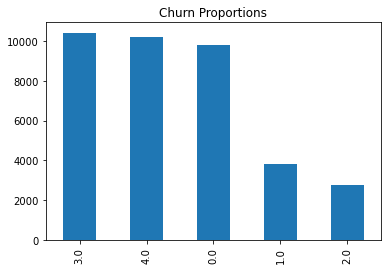

In [ ]:
# python check if dataset is imbalanced : https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

target_count = df_train['churn_risk_score'].value_counts()
target_count.plot(kind='bar', title='Churn Proportions')

In [ ]:
labels = df_train[target_feature].values
df_train.drop(target_feature, axis=1, inplace=True, errors='ignore')
df_test.drop(target_feature, axis=1, inplace=True, errors='ignore')

### Replacing non_categorical_features NaN values - MICE imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer as MICE

# Create a copy of my original dataset
dataset_impute = df_train.copy()

# Apply MICE
dataset_impute_complete = MICE(max_iter=150, verbose=10, random_state=10).fit_transform(dataset_impute.values)

# Turning into df again
df_train = pd.DataFrame(data=dataset_impute_complete, columns=dataset_impute.columns, index=dataset_impute.index)

df_train.head()

[IterativeImputer] Completing matrix with shape (36992, 27)
[IterativeImputer] Ending imputation round 1/150, elapsed time 1.94
[IterativeImputer] Change: 113.37127013765223, scaled tolerance: 99.91405 
[IterativeImputer] Ending imputation round 2/150, elapsed time 3.74
[IterativeImputer] Change: 0.0, scaled tolerance: 99.91405 
[IterativeImputer] Early stopping criterion reached.


,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,...,feedback,joining_year,joining_month,joining_day,joining_dayOfWeek,joining_weekdayName,joining_week,joining_weekOfYear,joining_dayOfYear,joining_daysInMonth
0,18.0,0.0,2.0,3.0,0.0,1.0,1.0,2.0,17.0,300.63,...,4.0,2017.0,8.0,17.0,3.0,4.0,33.0,33.0,229.0,31.0
1,32.0,0.0,0.0,4.0,0.0,1.0,1.0,1.0,16.0,306.34,...,5.0,2017.0,8.0,28.0,0.0,1.0,35.0,35.0,240.0,31.0
2,44.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0,14.0,516.16,...,3.0,2016.0,11.0,11.0,4.0,0.0,45.0,45.0,316.0,30.0
3,37.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,11.0,53.27,...,3.0,2016.0,10.0,29.0,5.0,2.0,43.0,43.0,303.0,31.0
4,31.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,20.0,113.13,...,3.0,2017.0,9.0,12.0,1.0,5.0,37.0,37.0,255.0,30.0


In [ ]:
print("NaN Values:",df_train.isna().any().sum())

NaN Values: 0


In [ ]:
print("NaN Values:",df_test.isna().any().sum())

NaN Values: 1


In [ ]:
df_test.fillna(df_test.mean(), inplace=True)
print("NaN Values:",df_test.isna().any().sum())

NaN Values: 0


In [ ]:
# # Check column type
# for col in df_train.columns:
#     print("{} : {}".format(col,df_train[col].dtype))

### Splitting Data into train-cv

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(df_train, labels, test_size=0.15, shuffle=True)

### Scaling data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(df_test)

### Modelling & Cross-Validation

In [ ]:
import sklearn.utils as skutils
class_weights = skutils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.7571153383096557,
 1: 1.950558312655087,
 2: 2.7012886597938146,
 3: 0.7068225244464427,
 4: 0.7238259668508288}

In [ ]:
sample_weights = skutils.class_weight.compute_sample_weight('balanced', y_train)
# sample_weights

In [ ]:
# # helper functions
# import sklearn.metrics as skm
# def log1p(vec):
#     return np.log1p(abs(vec))

# def expm1(x):
#     return np.expm1(x)

# def clipExp(vec):
#     return np.clip(expm1(vec), 0, None)

# def printScore(y_train, y_train_pred):
#     print(skm.f1_score(y_train, y_train_pred, average="macro"))

In [ ]:
# !pip install hyperopt > /dev/null

In [ ]:
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from sklearn.model_selection import cross_val_score

# space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
#         'max_depth': hp.quniform('max_depth', 10, 12, 10),
#         'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
#         'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
#         'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
#         'n_estimators' : hp.choice('n_estimators', [10, 50])
#     }

# def objective(space):
#     model = RandomForestClassifier(criterion = space['criterion'], 
#                                    max_depth = space['max_depth'],
#                                  max_features = space['max_features'],
#                                  min_samples_leaf = space['min_samples_leaf'],
#                                  min_samples_split = space['min_samples_split'],
#                                  n_estimators = space['n_estimators'], 
#                                  )
    
#     accuracy = cross_val_score(model, X_train_scaled, y_train, cv = 4, n_jobs=-1, verbose=0).mean()

#     # We aim to maximize accuracy, therefore we return it as a negative value
#     return {'loss': -accuracy, 'status': STATUS_OK }
    
# trials = Trials()
# best = fmin(fn= objective,
#             space= space,
#             algo= tpe.suggest,
#             max_evals = 20,
#             trials= trials)
# best

In [ ]:
# !pip3 install git+https://github.com/hyperopt/hyperopt-sklearn > /dev/null

  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-c0gis9cx


In [ ]:
# from hpsklearn import HyperoptEstimator, any_classifier
# from hyperopt import tpe

# # Instantiate a HyperoptEstimator with the search space and number of evaluations
# estim = HyperoptEstimator( classifier=any_classifier('clf'),  
#                             algo=tpe.suggest, trial_timeout=300)

# # Search the hyperparameter space based on the data
# estim.fit( X_train_scaled, y_train )

# # Predicting on CV data
# print("Accuracy on Test Data: {}".format(estim.score(X_cv_scaled, y_cv)))
# print(estim.best_model())

In [ ]:
# import json
# print(json.dumps(nested_dict, sort_keys=True, indent=4))

In [ ]:
# from pprint import pprint
# print("Predicting using RandomForest")
# # alg = XGBClassifier
# alg = RandomForestClassifier(bootstrap=False, criterion='entropy',
#                        max_features=0.34067731242165933, n_estimators=223,
#                        n_jobs=1, random_state=4, verbose=False)
# alg.fit(X_train_scaled, y_train)
# predictions = alg.predict(X_cv_scaled)
# # pprint(alg.get_params())

In [ ]:
# model_score(y_cv,predictions)

In [ ]:
# !pip3 install lazypredict > /dev/null
# from lazypredict.Supervised import LazyClassifier
# clf = LazyClassifier(verbose=0,ignore_warnings=True)
# models, predictions = clf.fit(X_train_scaled, X_cv, y_train, y_cv)
# models

In [ ]:
# from hyperopt import hp
# import numpy as np
# from sklearn.metrics import mean_squared_error


# # XGB parameters
# xgb_clf_params = {
#     'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
#     'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
#     'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
#     'reg_alpha':        hp.choice('reg_alpha',        np.arange(0.1, 1, 0.1)),
#     'reg_lambda':       hp.choice('reg_lambda',       np.arange(1, 5, 0.5)),
#     'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 1, 0.1)),
#     'gamma':            hp.choice('gamma',            np.arange(0.1, 2, 0.1)),
#     'subsample':        hp.uniform('subsample', 0.2, 1),
#     'n_estimators':     hp.choice('n_estimators',     np.arange(100, 3000, 100, dtype=int)),
# }

# xgb_fit_params = {
#     'eval_metric': 'mlogloss',
#     'early_stopping_rounds': 10,
#     'verbose': False
# }
# xgb_para = dict()
# xgb_para['clf_params'] = xgb_clf_params
# xgb_para['fit_params'] = xgb_fit_params
# xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# # LightGBM parameters
# lgb_clf_params = {
#     'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
#     'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
#     'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
#     'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
#     'subsample':        hp.uniform('subsample', 0.8, 1),
#     'n_estimators':     100,
# }
# lgb_fit_params = {
# #     'eval_metric': 'l2',
#     'early_stopping_rounds': 10,
#     'verbose': False
# }
# lgb_para = dict()
# lgb_para['clf_params'] = lgb_clf_params
# lgb_para['fit_params'] = lgb_fit_params
# lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# # CatBoost parameters
# ctb_clf_params = {
#     'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
#     'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
#     'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
#     'n_estimators':      100,
# #     'eval_metric':       'RMSE',
# }
# ctb_fit_params = {
#     'early_stopping_rounds': 10,
#     'verbose': False
# }
# ctb_para = dict()
# ctb_para['clf_params'] = ctb_clf_params
# ctb_para['fit_params'] = ctb_fit_params
# ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as ctb
# from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


# class HPOpt(object):

#     def __init__(self, x_train, x_test, y_train, y_test):
#         self.x_train = x_train
#         self.x_test  = x_test
#         self.y_train = y_train
#         self.y_test  = y_test

#     def process(self, fn_name, space, trials, algo, max_evals):
#         fn = getattr(self, fn_name)
#         try:
#             result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
#         except Exception as e:
#             return {'status': STATUS_FAIL,
#                     'exception': str(e)}
#         return result, trials

#     def xgb_clf(self, para):
#         clf = xgb.XGBClassifier(**para['clf_params'], n_jobs=-1)
#         return self.train_clf(clf, para)

#     def lgb_clf(self, para):
#         clf = lgb.LGBMClassifier(**para['clf_params'], n_jobs=-1)
#         return self.train_clf(clf, para)

#     def ctb_clf(self, para):
#         clf = ctb.CatBoostClassifier(**para['clf_params'], n_jobs=-1)
#         return self.train_clf(clf, para)

#     def train_clf(self, clf, para):
#         clf.fit(self.x_train, self.y_train,
#                 eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
#                 **para['fit_params'])
#         pred = clf.predict(self.x_test)
#         loss = para['loss_func'](self.y_test, pred)
#         return {'loss': loss, 'status': STATUS_OK}

In [ ]:
# obj = HPOpt(X_train_scaled, X_cv_scaled, y_train, y_cv)

# xgb_opt = obj.process(fn_name='xgb_clf', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
# # lgb_opt = obj.process(fn_name='lgb_clf', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
# # ctb_opt = obj.process(fn_name='ctb_clf', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
# print(xgb_opt)

In [ ]:
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

clf = xgb.XGBClassifier()


# XGB parameters
param_grid = {
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'subsample': np.arange(0.3, 1, 0.1),
    'colsample_bytree': np.arange(0.3, 1, 0.1),
    'colsample_bylevel': np.arange(0.3, 1, 0.1),
    'max_depth': np.arange(5, 16, 1, dtype=int),
    'min_child_weight': np.arange(1, 10, 1, dtype=int),
    'reg_alpha': np.arange(0.1, 1, 0.1),
    'reg_lambda': np.arange(1, 5, 0.5),
    'gamma': np.arange(0.1, 2, 0.1),
    'n_estimators': np.arange(100, 3000, 100, dtype=int),
}

fit_params = {
    'eval_metric': 'mlogloss',
    'early_stopping_rounds': 10,
    'eval_set': [(X_cv_scaled, y_cv)],
    'verbose': False
}

# https://stats.stackexchange.com/questions/431022/error-while-performing-multiclass-classification-using-gridsearch-cv
multiclass_scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted')

rs_clf = RandomizedSearchCV(clf,
                            param_grid,
                            n_iter=50,
                            n_jobs=-1,
                            verbose=2,
                            scoring=multiclass_scorer,
                            random_state=42)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train_scaled, y_train, **fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 11.9min finished


Randomized search time: 718.5847144126892
Best score: 0.7487969971157384
Best params: 
colsample_bylevel: 0.4
colsample_bytree: 0.7000000000000002
gamma: 1.9000000000000001
learning_rate: 0.1
max_depth: 6
min_child_weight: 7
n_estimators: 200
reg_alpha: 0.1
reg_lambda: 2.0
subsample: 0.7000000000000002


### Predicting on test Data

In [ ]:
# On test data
# trained_model = alg ## Selecting the model to be used
trained_model = rs_clf
read = pd.read_csv('/home/jovyan/work/dataset/churn_test.csv')
predictions_trained_model_test = trained_model.predict(X_test_scaled)
# predictions_trained_model_test = estim.predict(X_test_scaled)

In [ ]:
submission = pd.DataFrame({
        "customer_id": read["customer_id"],
        "churn_risk_score": predictions_trained_model_test
    })

# revert back 0 to 5 for predictions
submission[target_feature] = submission[target_feature].apply(lambda x:5 if x == 0 else x)
submission[target_feature].value_counts()

5.0    6687
3.0    5558
4.0    4661
1.0    1831
2.0    1182
Name: churn_risk_score, dtype: int64

In [ ]:
submission.to_csv('submission.csv', index=False)